# Logistic Regression

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.classification_metrics import classification

First of all, we load the data

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/breast_cancer.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/breast_cancer.parquet')

In [5]:
y_train = train.diagnosis
X_train = train.drop(columns=['diagnosis'])

In [6]:
y_validation = validation.diagnosis
X_validation = validation.drop(columns=['diagnosis'])

We are going to scale the data because it gives convergence problems.

In [7]:
scaler = StandardScaler().fit(X_train, y_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

We are going to compute different models varying the penalty terms, if the solver is modified it's due to incompatibility with the penalties that are supported by each one.

Without penalty term:

In [9]:
lr = LogisticRegression(penalty=None)

Adding the $l_2$ term to the cost function: $$ \frac{1}{2}||\beta||_2^2 = \frac{1}{2}\beta^T\beta \ , $$ where $\beta$ is the vector of coefficients.

In [10]:
lr_l2 = LogisticRegression()

Instead of the $l_2$ penalty, the $l_1$ penalty: $$||\beta||_1=\sum_{i=1}^p|\beta_i| \,$$ where $p$ is the length of $\beta$, that is, the number of features.

In [11]:
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear')

Lastly, the ElasticNet penalty: $$\frac{1-\rho}{2}||\beta||_2^2 + \rho||\beta||_1 \ ,$$ where $\rho$ is a parameter between 0 and 1 that controls the strength of the $l_1$ and $l_2$ regularizations. Note that if $\rho=1$, ElasticNet is equivalent to $l_1$ and if $\rho=0$, is the same as $l_2$.

In [12]:
lr_en1 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.25, max_iter=1000)
lr_en2 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
lr_en3 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.75, max_iter=3000)

In [13]:
models_list = [lr, lr_l2, lr_l1, lr_en1, lr_en2 , lr_en3]
names_list = ['LR', 'LR_l2', 'LR_l1', 'LR_en_0.25', 'LR_en_0.5', 'LR_en_0.75']

In [14]:
metrics = classification(models_list, names_list, '../../../data/metrics/breast_cancer/logistic_regression.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_AUC,Validation_AUC,delta%
LR,0.050864,1.000000,0.993734,-0.626566
LR_l2,0.017952,0.999117,0.994361,-0.476076
LR_l1,0.013966,0.999171,0.978070,-2.111828
LR_en_0.25,0.189036,0.999037,0.992481,-0.656234
LR_en_0.5,0.199981,0.999144,0.988095,-1.105843
LR_en_0.75,0.404916,0.999171,0.983083,-1.610159


Every model is super good in terms of accuracy, overfit and speed. Let's check the amount of null coefficients we get:

In [15]:
sparsity_lr = np.mean(lr.coef_.ravel() == 0) * 100
sparsity_lr_l2 = np.mean(lr_l2.coef_.ravel() == 0) * 100
sparsity_lr_l1 = np.mean(lr_l1.coef_.ravel() == 0) * 100
sparsity_lr_en1 = np.mean(lr_en1.coef_.ravel()) * 100
sparsity_lr_en2 = np.mean(lr_en2.coef_.ravel()) * 100
sparsity_lr_en3 = np.mean(lr_en3.coef_.ravel()) * 100

print("Sparsity without penalty term:", round(sparsity_lr, 2), '%')
print("Sparsity with L2 penalty:", round(sparsity_lr_l2, 2), '%')
print("Sparsity with L1 penalty:", round(sparsity_lr_l1, 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.25:", round(sparsity_lr_en1, 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.5:", round(sparsity_lr_en2, 2), '%')
print("Sparsity with ElasticNet penalty and l1 ratio=0.75:", round(sparsity_lr_en3, 2), '%')

Sparsity without penalty term: 0.0 %
Sparsity with L2 penalty: 0.0 %
Sparsity with L1 penalty: 56.67 %
Sparsity with ElasticNet penalty and l1 ratio=0.25: 38.69 %
Sparsity with ElasticNet penalty and l1 ratio=0.5: 38.16 %
Sparsity with ElasticNet penalty and l1 ratio=0.75: 37.75 %


Despite the fact that the model with L2 penalty includes all predictors, we will select it as the best model. 

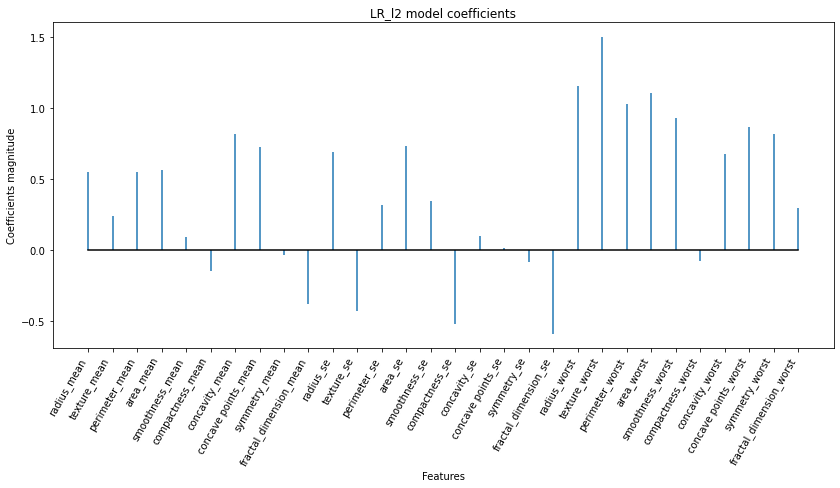

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.stem(X_train.columns, lr_l2.coef_.ravel(), markerfmt=' ', basefmt='k-')
plt.xticks(rotation=60, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('LR_l2 model coefficients');

At this moment that we have chosen our final model, we are going to retrain it with all the train and validation data, and evaluate it with the test data. 

In [17]:
test =  pd.read_parquet('../../../data/model_input/test_sets/breast_cancer.parquet')

In [18]:
y_test = test.diagnosis
X_test = test.drop(columns=['diagnosis'])

In [19]:
retrain = pd.concat([train, validation])

In [20]:
y_retrain = retrain.diagnosis
X_retrain = retrain.drop(columns=['diagnosis'])

We rescale with the parameters of the new dataset

In [21]:
scaler_retrain = StandardScaler().fit(X_retrain, y_retrain)

In [22]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [23]:
model = LogisticRegression().fit(X_retrain_scaled, y_retrain)

Let's check the coefficients of the model again

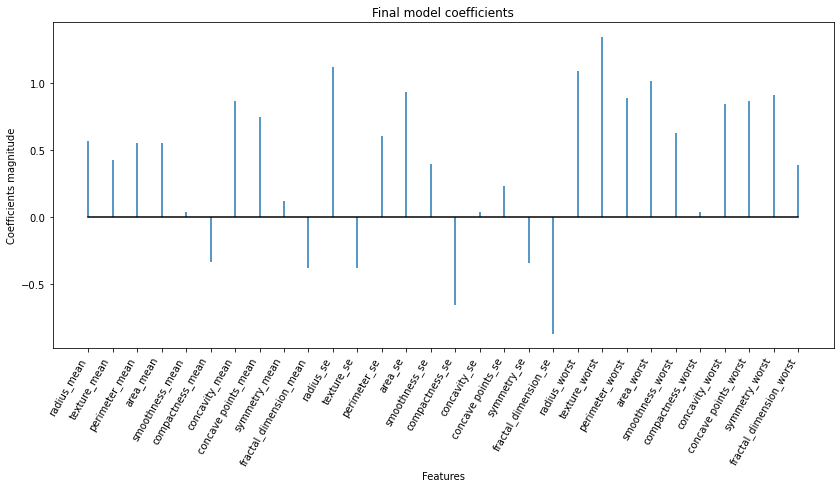

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.stem(X_retrain.columns, model.coef_.ravel(), markerfmt=' ', basefmt='k-')
plt.xticks(rotation=60, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model coefficients');

Essentially nothing has changed, just a few ones changed their magnitude, but not sign. Lastly, let's see the performance of the model:

In [25]:
test_pred = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, test_pred)
print('Test AUC:', round(auc, 4))

Test AUC: 0.9896


In [26]:
dump(model, 'best_logistic_regression.joblib')

['best_logistic_regression.joblib']